In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import scipy.stats as st
import math
import datetime
import missingno as msno
from scipy.stats import norm, skew
from sklearn import metrics
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor

from termcolor import colored
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#to see model hyperparameters
from sklearn import set_config
set_config(print_changed_only = False)

# to show all columns
pd.set_option('display.max_columns', 15)


In [31]:
car = pd.read_csv("Car details v3.csv")
df = car.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [32]:
categoric_columns = ["fuel", "transmission", "owner", "seller_type"]
for column in categoric_columns:
    df[column] = df[column].astype("category")

In [33]:
df["car_brand_name"] = df["name"].str.extract('([^\s]+)')
df["car_brand_name"] = df["car_brand_name"].astype("category")
df["engine"] = df["engine"].str.extract('([^\s]+)').astype("float")
df["mileage"] = df["mileage"].str.extract('([^\s]+)').astype("float")
df["max_power"] = df["max_power"].str.extract('([^\s]+)')
df["max_power"] = df["max_power"][~(df["max_power"] == "bhp")]
df["max_power"] = df["max_power"].astype("float")
df["car_age"] = (datetime.datetime.now().year) - (df["year"])
df.drop(["name", "year", "torque"], axis = 1, inplace = True)


In [34]:
df.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_brand_name,car_age
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,5.0,Maruti,10
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0,Skoda,10
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,5.0,Honda,18
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,5.0,Hyundai,14
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,5.0,Maruti,17


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   selling_price   8128 non-null   int64   
 1   km_driven       8128 non-null   int64   
 2   fuel            8128 non-null   category
 3   seller_type     8128 non-null   category
 4   transmission    8128 non-null   category
 5   owner           8128 non-null   category
 6   mileage         7907 non-null   float64 
 7   engine          7907 non-null   float64 
 8   max_power       7912 non-null   float64 
 9   seats           7907 non-null   float64 
 10  car_brand_name  8128 non-null   category
 11  car_age         8128 non-null   int64   
dtypes: category(5), float64(4), int64(3)
memory usage: 486.3 KB


In [36]:
df.isnull().sum()

selling_price       0
km_driven           0
fuel                0
seller_type         0
transmission        0
owner               0
mileage           221
engine            221
max_power         216
seats             221
car_brand_name      0
car_age             0
dtype: int64

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
selling_price,8128.0,638271.807702,806253.403508,29999.0,254999.00,450000.0,675000.00,10000000.0
km_driven,8128.0,69819.510827,56550.554958,1.0,35000.00,60000.0,98000.00,2360457.0
mileage,7907.0,19.418783,4.037145,0.0,16.78,19.3,22.32,42.0
engine,7907.0,1458.625016,503.916303,624.0,1197.00,1248.0,1582.00,3604.0
max_power,7912.0,91.517919,35.822499,0.0,68.05,82.0,102.00,400.0
seats,7907.0,5.416719,0.959588,2.0,5.00,5.0,5.00,14.0
car_age,8128.0,10.195989,4.044249,4.0,7.00,9.0,13.00,41.0


In [38]:
df.describe(include = "category").T

,count,unique,top,freq
fuel,8128,4,Diesel,4402
seller_type,8128,3,Individual,6766
transmission,8128,2,Manual,7078
owner,8128,5,First Owner,5289
car_brand_name,8128,32,Maruti,2448


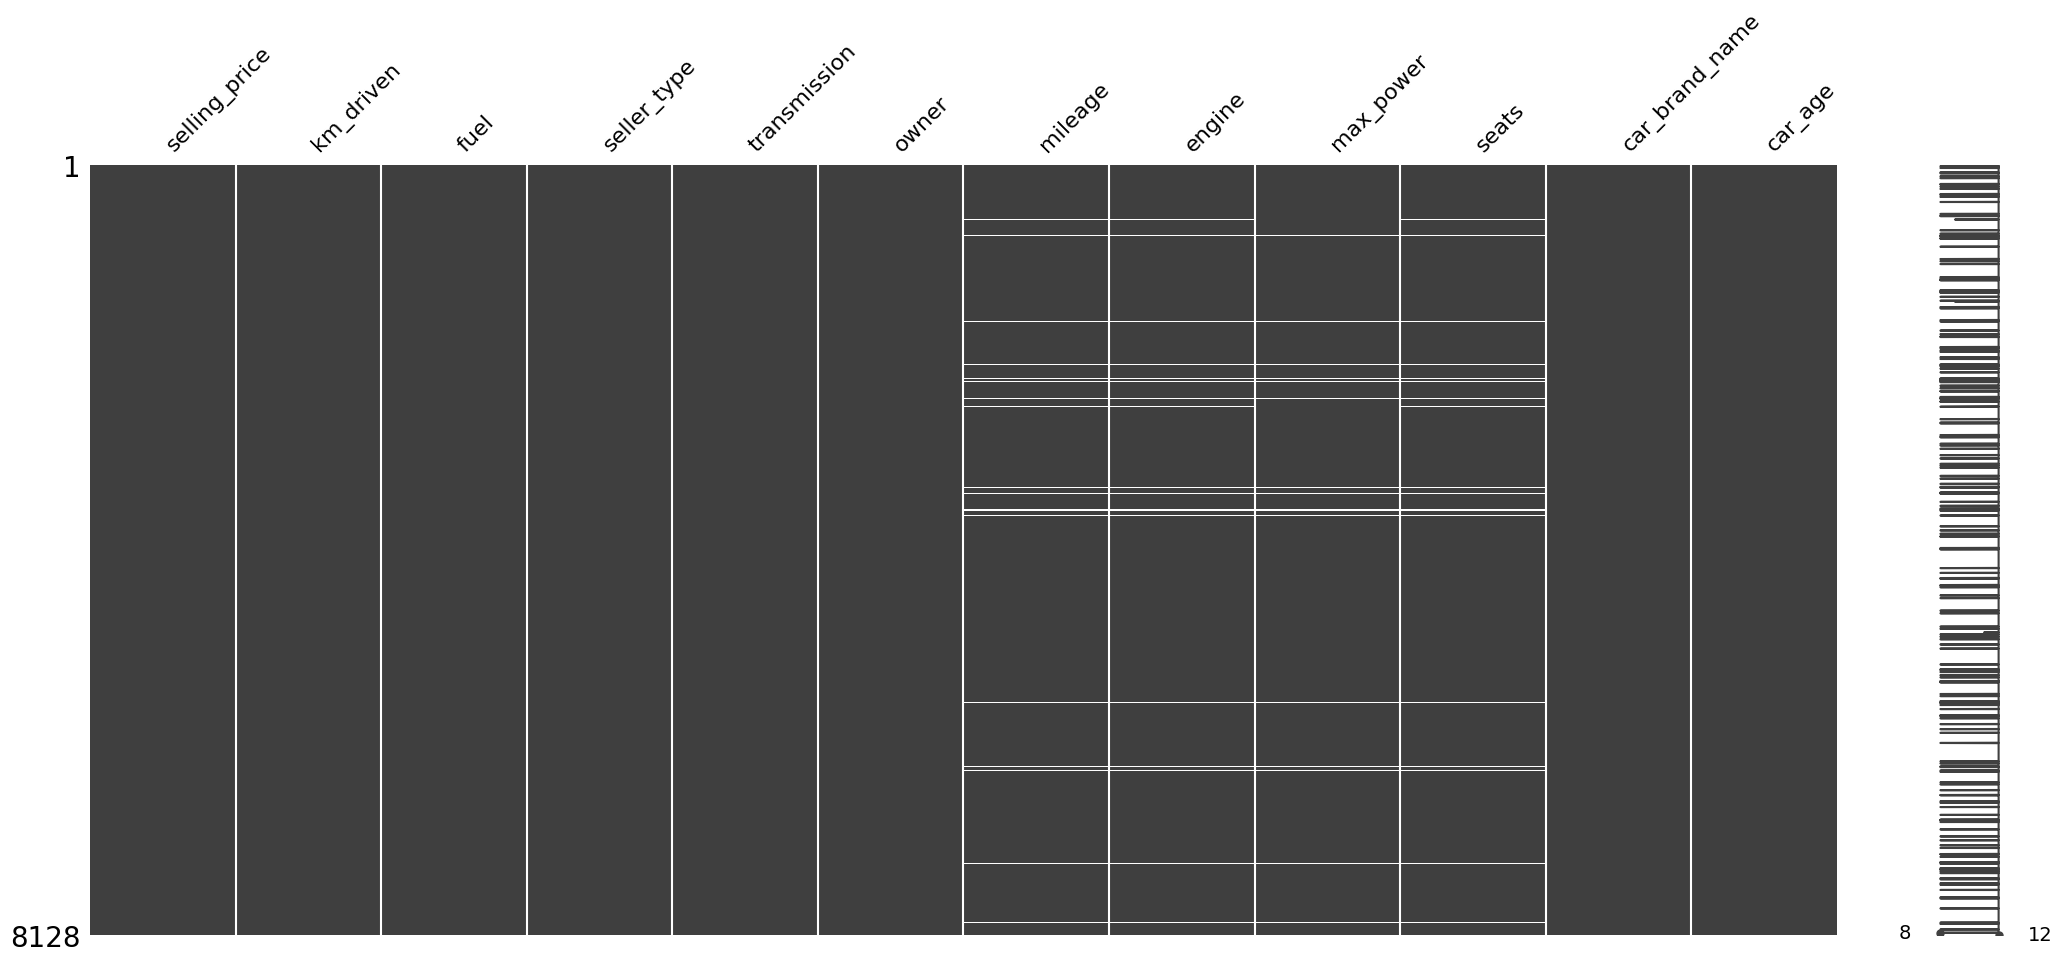

In [39]:
msno.matrix(df);

<Figure size 1000x500 with 0 Axes>

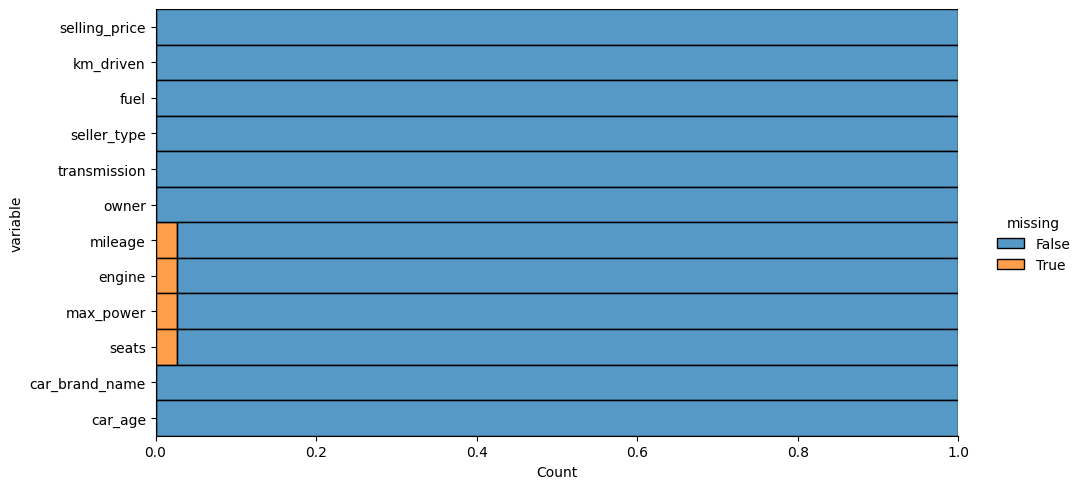

In [40]:
plt.figure(figsize = (10, 5))
sns.displot(
    data = df.isna().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 2
);
plt.show()

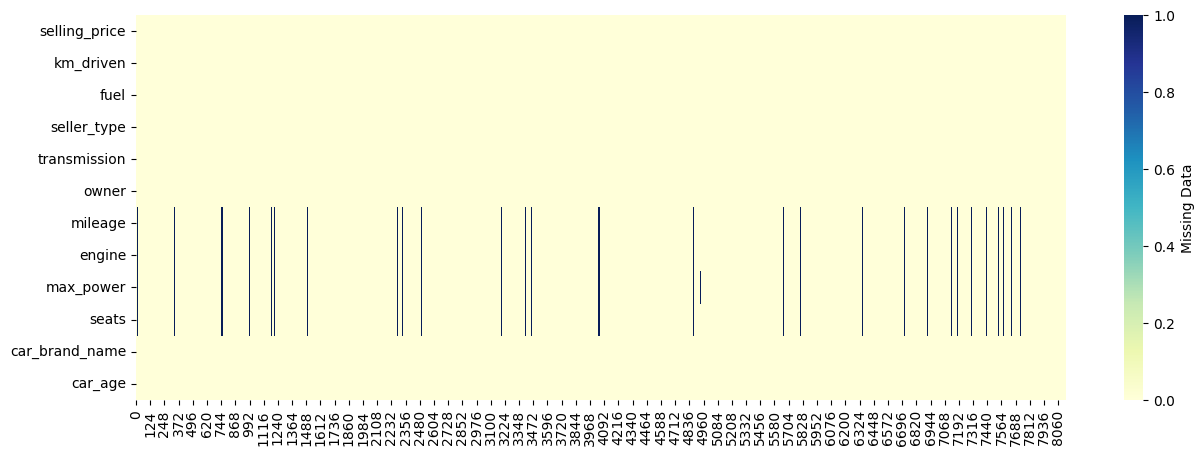

In [41]:
plt.figure(figsize = (15, 5))
sns.heatmap(df.isna().transpose(),
            cmap = "YlGnBu",
            cbar_kws = {'label': 'Missing Data'});
plt.show()

In [42]:
numeric_data = [column for column in df.select_dtypes(["int", "float"])]
categoric_data = [column for column in df.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    df[col].fillna(df[col].median(), inplace = True)
        
#replace missing values in each categorical column with the most frequent value
for col in categoric_data:
    df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [43]:
df.isnull().sum().sum()

0

In [44]:
print("Frecuencia de clase de la variable 'transmission': \n\n", df["transmission"].value_counts())

print("_____________________________________________________________________________________")

print("Frecuencia de clase de la variable 'seller_type': \n\n", df["seller_type"].value_counts())

print("_____________________________________________________________________________________")

print("Frecuencia de clase de la variable 'owner': \n\n", df["owner"].value_counts())

print("_____________________________________________________________________________________")

print("Frecuencia de clase de la variable 'car_brand_name': \n\n", df["car_brand_name"].value_counts())

Frecuencia de clase de la variable 'transmission': 

 transmission
Manual       7078
Automatic    1050
Name: count, dtype: int64
_____________________________________________________________________________________
Frecuencia de clase de la variable 'seller_type': 

 seller_type
Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: count, dtype: int64
_____________________________________________________________________________________
Frecuencia de clase de la variable 'owner': 

 owner
First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: count, dtype: int64
_____________________________________________________________________________________
Frecuencia de clase de la variable 'car_brand_name': 

 car_brand_name
Maruti           2448
Hyundai          1415
Mahindra          772
Tata              734
Toyota            488
Honda             467
Ford              39

In [45]:
df.to_csv("car_data_cleaned.csv", index=False)